Trying joblib.load...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying

Successfully loaded with joblib.load

Model type: RandomForestClassifier
Number of trees: 100
Feature names available: 213


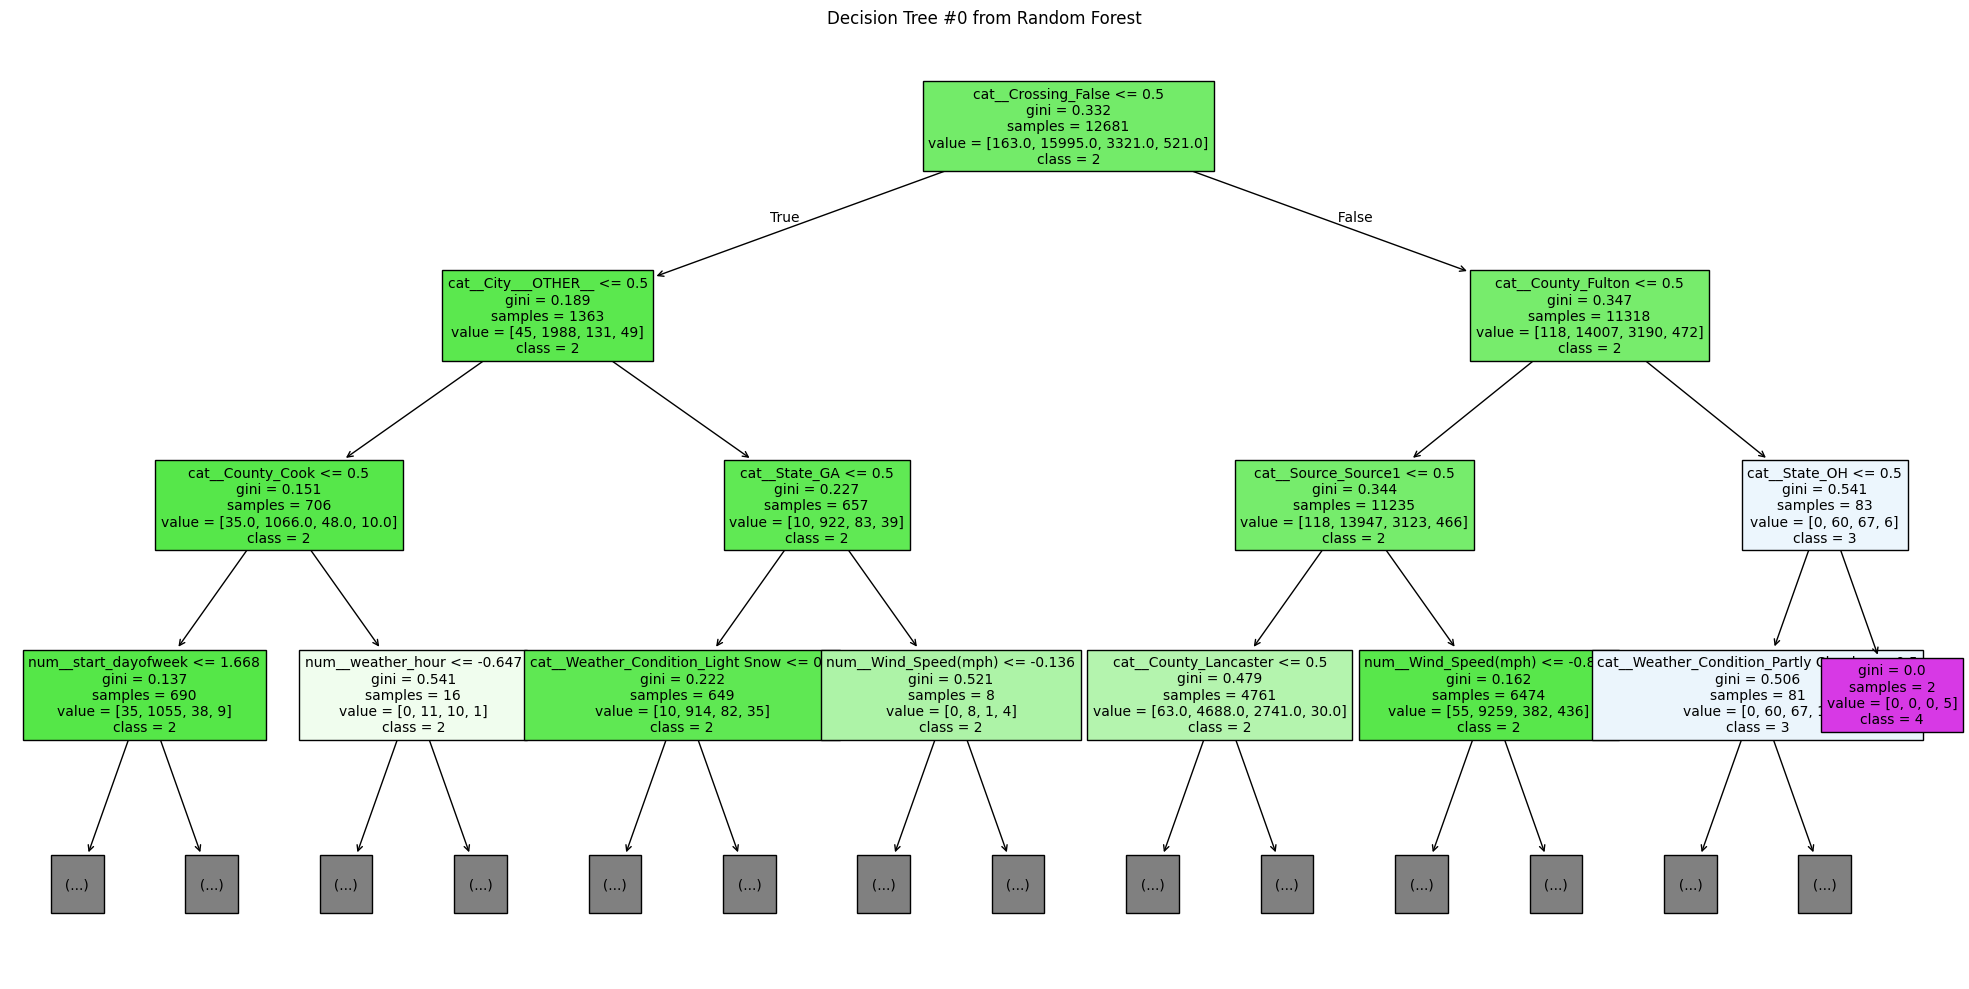

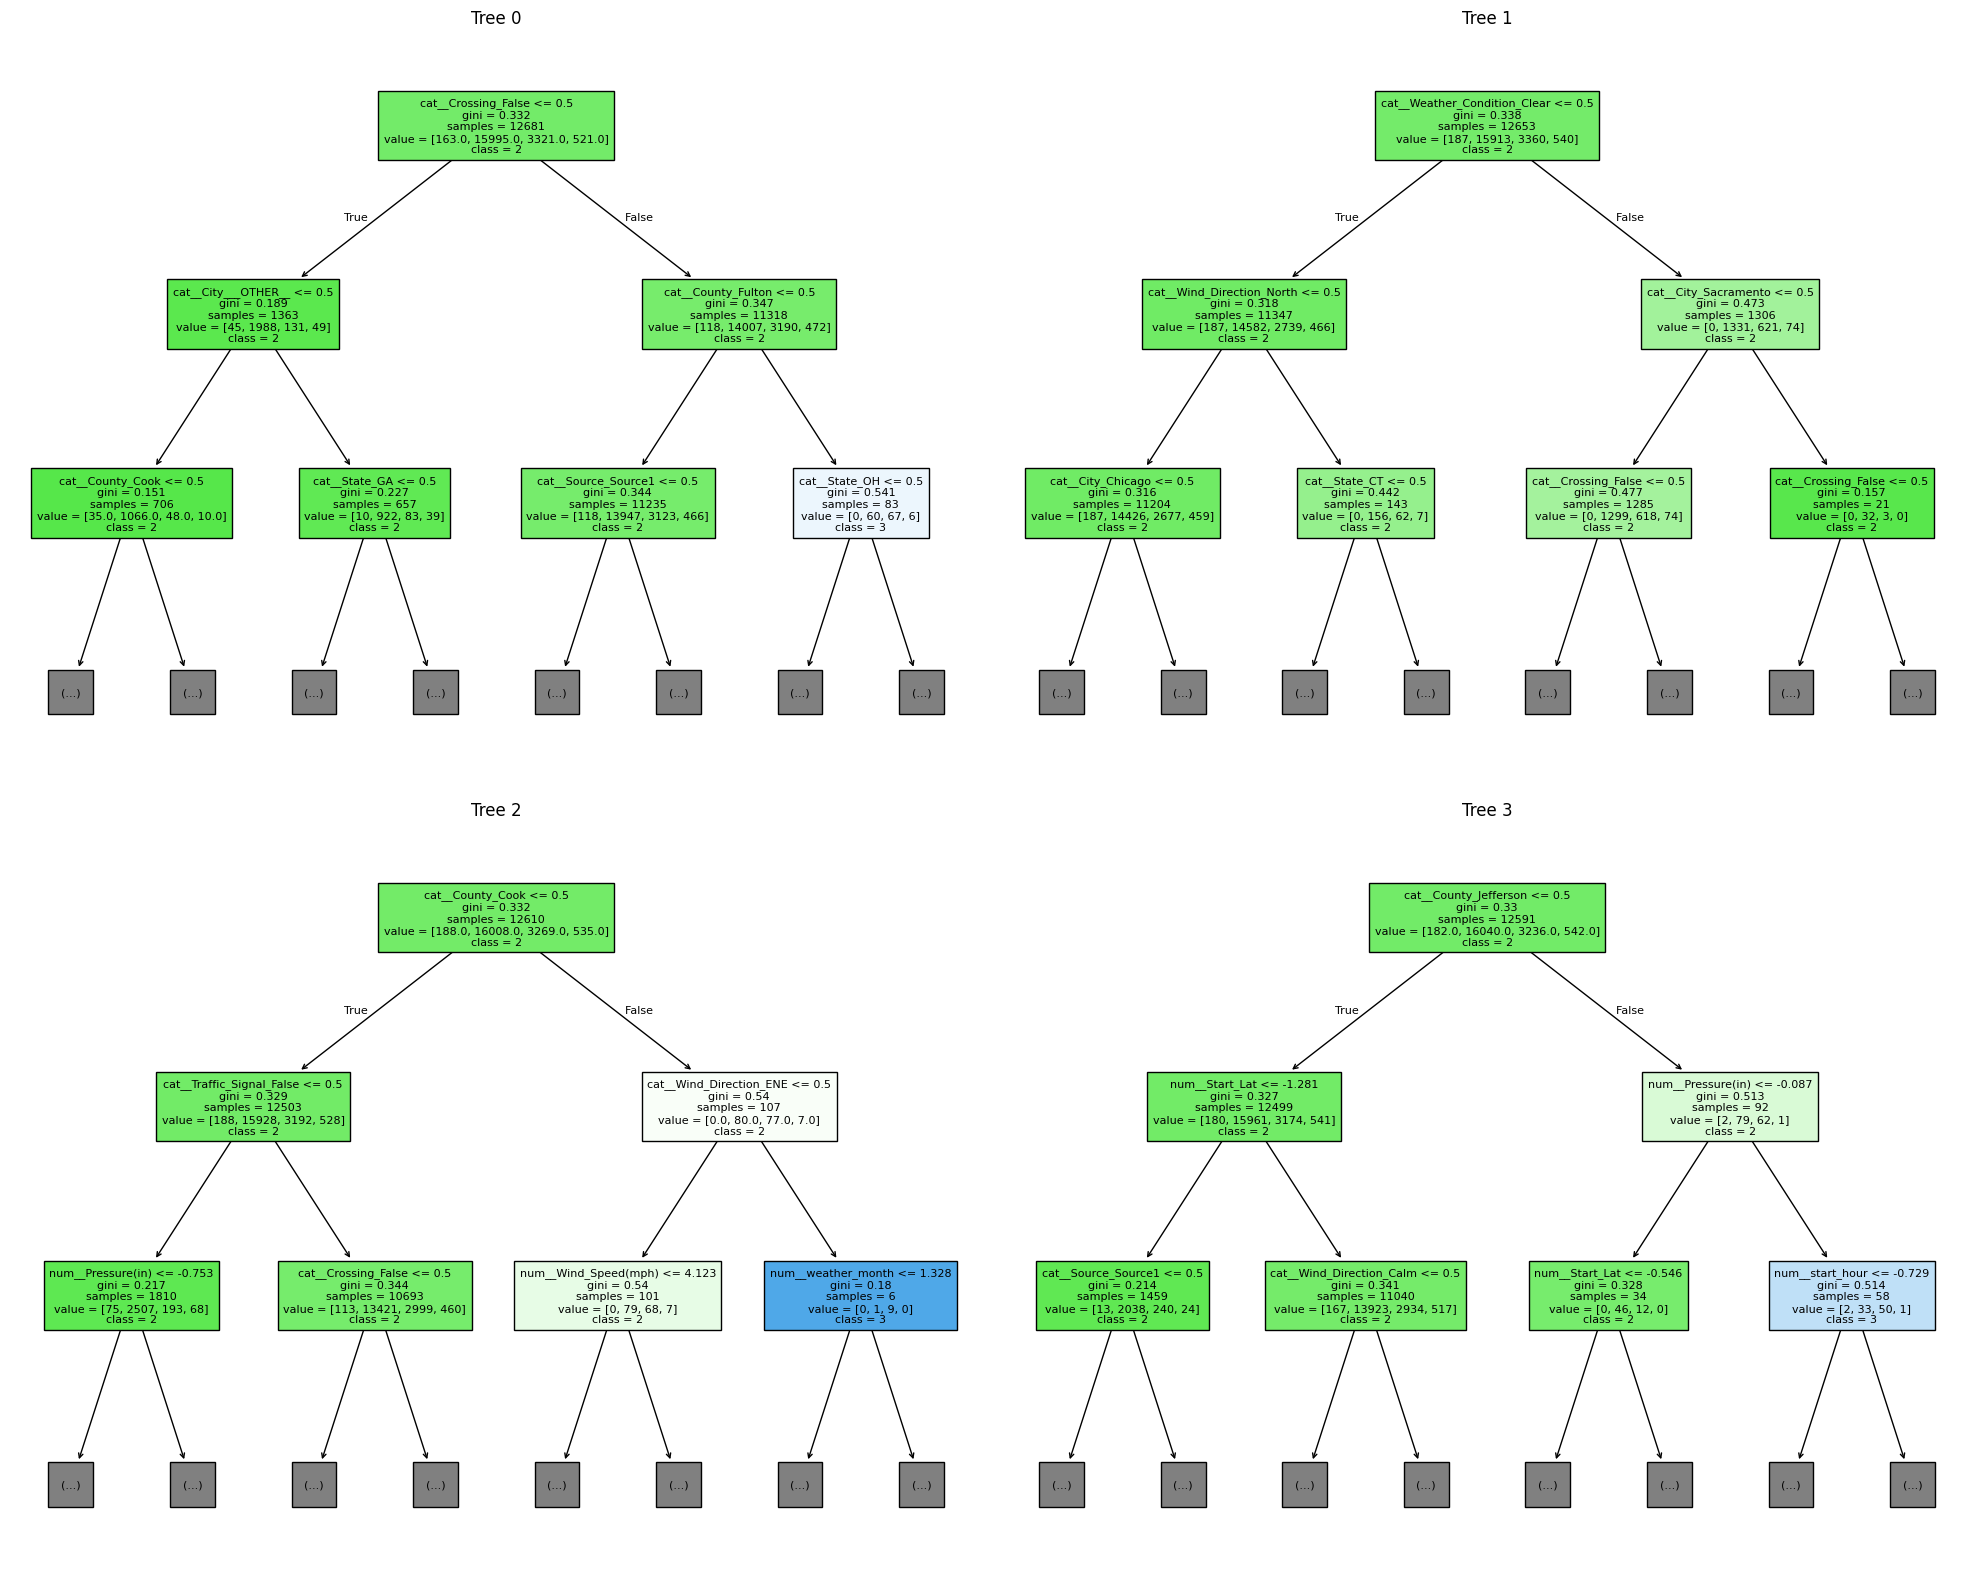

Number of features: 213

Total features with names: 213
Top 15 features by importance:


,feature,importance
1,num__Start_Lng,0.063577
12,cat__Source_Source1,0.062420
0,num__Start_Lat,0.062027
3,num__Pressure(in),0.055755
13,cat__Source_Source2,0.051990
2,num__Temperature(F),0.051497
6,num__start_hour,0.043091
5,num__Wind_Speed(mph),0.041448
9,num__weather_hour,0.040782
7,num__start_dayofweek,0.036476


In [11]:
import joblib
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import pickle
import sys
import pandas as pd

# Define the missing helper function that was used when saving
def _coerce_bool_to_str(val):
    """Helper to convert boolean to string for sklearn compatibility"""
    if isinstance(val, bool):
        return str(val)
    return val

# Make it available in the current module so unpickler can find it
sys.modules['__main__']._coerce_bool_to_str = _coerce_bool_to_str

# Load the saved model with multiple fallback strategies
loaded_model = None
strategies = [
    ("joblib.load", lambda: joblib.load("outputs/best_model.pkl")),
    ("pickle.load", lambda: pickle.load(open("outputs/best_model.pkl", "rb"))),
]

for name, loader in strategies:
    try:
        print(f"Trying {name}...")
        loaded_model = loader()
        print(f"Successfully loaded with {name}")
        break
    except Exception as e:
        print(f"{name} failed: {type(e).__name__}: {str(e)[:80]}")
        continue

if loaded_model is None:
    raise RuntimeError("Could not load model with any strategy. Check outputs/best_model.pkl exists and is valid.")

# Extract the Random Forest classifier and feature names (if available)
rf_model = loaded_model.named_steps["clf"]
preprocessor = loaded_model.named_steps.get("preprocessor")

feature_names = None
if preprocessor is not None:
    if hasattr(preprocessor, "get_feature_names_out"):
        feature_names = preprocessor.get_feature_names_out()
    elif hasattr(preprocessor, "get_feature_names"):
        feature_names = preprocessor.get_feature_names()

print(f"\nModel type: {type(rf_model).__name__}")
print(f"Number of trees: {len(rf_model.estimators_)}")
if feature_names is not None:
    print(f"Feature names available: {len(feature_names)}")
else:
    print("Feature names unavailable; using index-based names in plots.")

# Visualize the first tree (or any tree by index)
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0],  # First tree (change index for others)
          max_depth=3,  # Limit depth for readability
          filled=True,
          feature_names=feature_names if feature_names is not None else None,
          class_names=[str(c) for c in rf_model.classes_],
          fontsize=10)
plt.title("Decision Tree #0 from Random Forest")
plt.tight_layout()
plt.show()

# To see multiple trees
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
for idx, ax in enumerate(axes.flat):
    if idx < len(rf_model.estimators_):
        plot_tree(rf_model.estimators_[idx],
                  max_depth=2,
                  filled=True,
                  ax=ax,
                  feature_names=feature_names if feature_names is not None else None,
                  class_names=[str(c) for c in rf_model.classes_],
                  fontsize=8)
        ax.set_title(f"Tree {idx}")
plt.tight_layout()
plt.show()

# Get feature importances and display top 15 with names
importances = rf_model.feature_importances_
print("Number of features:", len(importances))

if feature_names is not None and len(feature_names) == len(importances):
    print(f"\nTotal features with names: {len(feature_names)}")
    # Build a sorted table of importances with names
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    imp_df = imp_df.sort_values(by="importance", ascending=False)
    print("Top 15 features by importance:")
    display(imp_df.head(15))
else:
    print("\nFeature names unavailable or length mismatch; showing indices only.")
    print("Top 15 most important features (by index):")
    top_indices = importances.argsort()[-15:][::-1]
    for idx in top_indices:
        print(f"  Feature {idx}: {importances[idx]:.4f}")